In [1]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [4]:
%run "$utils_path"
%run "$tableGAN_path"
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [5]:
n_epochs = 20
n_critic = 10
adam_lr = 0.0002
adam_beta1 = 0.5
model_dir = ".\\Model\\tableGAN_ckpt\\compare_adult\\"
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

image_dir = ".\\Images"
timer_dir = ".\\Timers"
dataset_dir = ".\\Datasets"
retrain = True

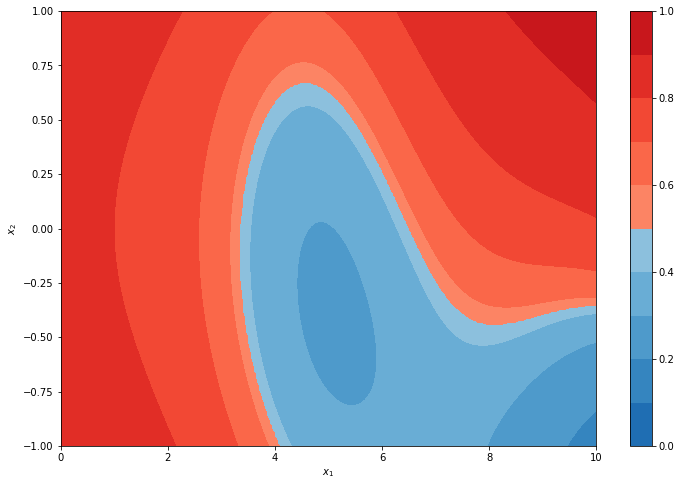

In [6]:
n_cols = 10
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = matplotlib.cm.get_cmap('Blues_r')(np.linspace(0.2, 0.6, n_cols))
colors2 = matplotlib.cm.get_cmap('Reds')(np.linspace(0.4, 0.8, n_cols))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap_br = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def classifier_func(x1, x2):
    a = 0.1 * (x1 - 5)**2 + (x2)**2 - 0.5 + 0.2 * tf.sqrt(x1) - 0.1*x1 + 0.005*x1**3 * x2 + 0.5*np.sin(x1) + 0.3*np.cos(x2)
    b = tf.sign(a) * (tf.abs(a))**(1/2)
    return(tf.math.sigmoid(b).numpy())


fig, ax = plt.subplots(figsize=[12,8])
def plot_heatmap(ax, heat_map_res = 200, incl_axis_labels = True, incl_colorbar = True, ret_contour = True):
    x1 = np.linspace(0, 10, heat_map_res)
    x2 = np.linspace(-1, 1, heat_map_res)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    
    y_mesh = classifier_func(x1_mesh, x2_mesh)
    cont1 = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels = np.linspace(0, 1, n_cols + 1), cmap = cmap_br)
    if (incl_axis_labels):
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_2$")
    if incl_colorbar:
        plt.colorbar(cont1, ax = ax)
    if ret_contour:
        return cont1

plot_heatmap(ax)
plt.savefig(os.path.join(image_dir, "prediction_func_for_cf_testing.svg"))

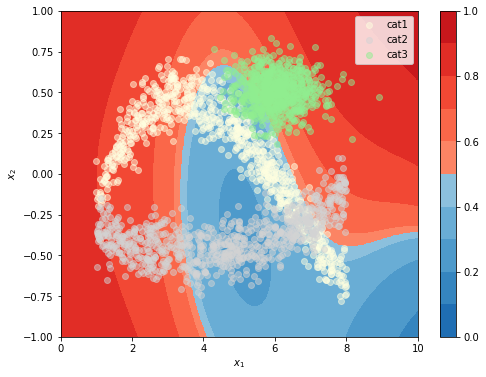

In [7]:
def classifier(data):
    return(classifier_func(data["x1"], data["x2"]))

n_train = 5000

x1_low, x1_high = 1,8
np.random.seed(1)

def sample_x1_given_x3(x3):
    x1_given_cat1_or_cat2 = np.random.uniform(x1_low, x1_high, n_train)
    x1_given_cat3 = np.random.normal(6, sigma_x1 , n_train)
    return np.where(x3 == "cat3", x1_given_cat3, x1_given_cat1_or_cat2)

sigma_x2 = 0.1
sigma_x1 = 0.6
x3 = np.random.choice(["cat1","cat2", "cat3"], n_train)
x1 = sample_x1_given_x3(x3)

def mean_x2_given_x1_x3(x1, x3):
    cond_list = [x3 == "cat1", x3 == "cat2", x3 == "cat3"]
    choice_list = [0.01*(x1)**3 - 0.2*x1**2 + x1 - 1, 0.02*x1**2 - 0.15*x1 -0.2, 0.5]
    return np.select(cond_list, choice_list, default=0)

def sample_x2_given_x1_x3(x1,x3, sigma):
    return np.random.normal(mean_x2_given_x1_x3(x1, x3), sigma, n_train)

def conf_int_x2_given_x1_x3(x3, sigma_x1, sigma_x2, alpha = 0.05, n_steps = 100):
    if x3 == "cat1" or x3 == "cat2":
        x1 = np.linspace(x1_low, x1_high, n_steps)
        mean = mean_x2_given_x1_x3(x1, x3)
        return(x1, scipy.stats.norm.interval(1-alpha, loc=mean, scale=sigma_x2))
    elif x3 == "cat3":
        degree = np.linspace(0, np.pi, n_steps)
        x1 = 6 + np.cos(degree) * 1.96 *sigma_x1
        x2 = [mean_x2_given_x1_x3(1, "cat3") + np.sin(degree) * 1.96 * sigma_x2,
              mean_x2_given_x1_x3(1, "cat3") + np.sin(-degree) * 1.96 * sigma_x2]
        return x1, x2
    else:
        raise ValueError("The x3 paramter must be one of the values cat1, cat2 or cat3 and given in string format")

x2 = sample_x2_given_x1_x3(x1, x3, sigma_x2)
df_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
df_toy.to_csv(os.path.join(dataset_dir, "df_toy.csv"), index=False)
category_colors = ["lightyellow", "lightgrey", "lightgreen"]

def plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2, alpha = 0.05):
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat1", sigma_x1, sigma_x2, alpha =alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[0], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[0], linestyle = "dashed")
    
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat2", sigma_x1, sigma_x2, alpha = alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[1], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[1], linestyle = "dashed")
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat3", sigma_x1, sigma_x2, alpha=alpha)
    ax.plot(x1_grid, x2_confint[0], c=category_colors[2], linestyle="dashed")
    ax.plot(x1_grid, x2_confint[1], c=category_colors[2], linestyle="dashed")
    
    

fig, ax = plt.subplots(figsize=[8,6])
map_x3_to_col = lambda x3 : np.select([x3 == "cat1", x3 == "cat2", x3 == "cat3"], category_colors)
categories_unique = np.unique(df_toy["x3"])
plot_heatmap(ax)
for i, cat in enumerate(categories_unique):
    df_toy_subset = df_toy.loc[df_toy["x3"] == cat].head(750)
    plt.scatter(df_toy_subset["x1"], df_toy_subset["x2"], color = str(map_x3_to_col(cat)), alpha = 0.5, label = cat)
#plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)
plt.legend()
plt.savefig(os.path.join(image_dir, "Syn2D_cf.svg"), dpi=300)

In [8]:
%run "$tableGAN_path"
tg = TableGAN(df_toy, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = 0, adam_beta2 = 0.999,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

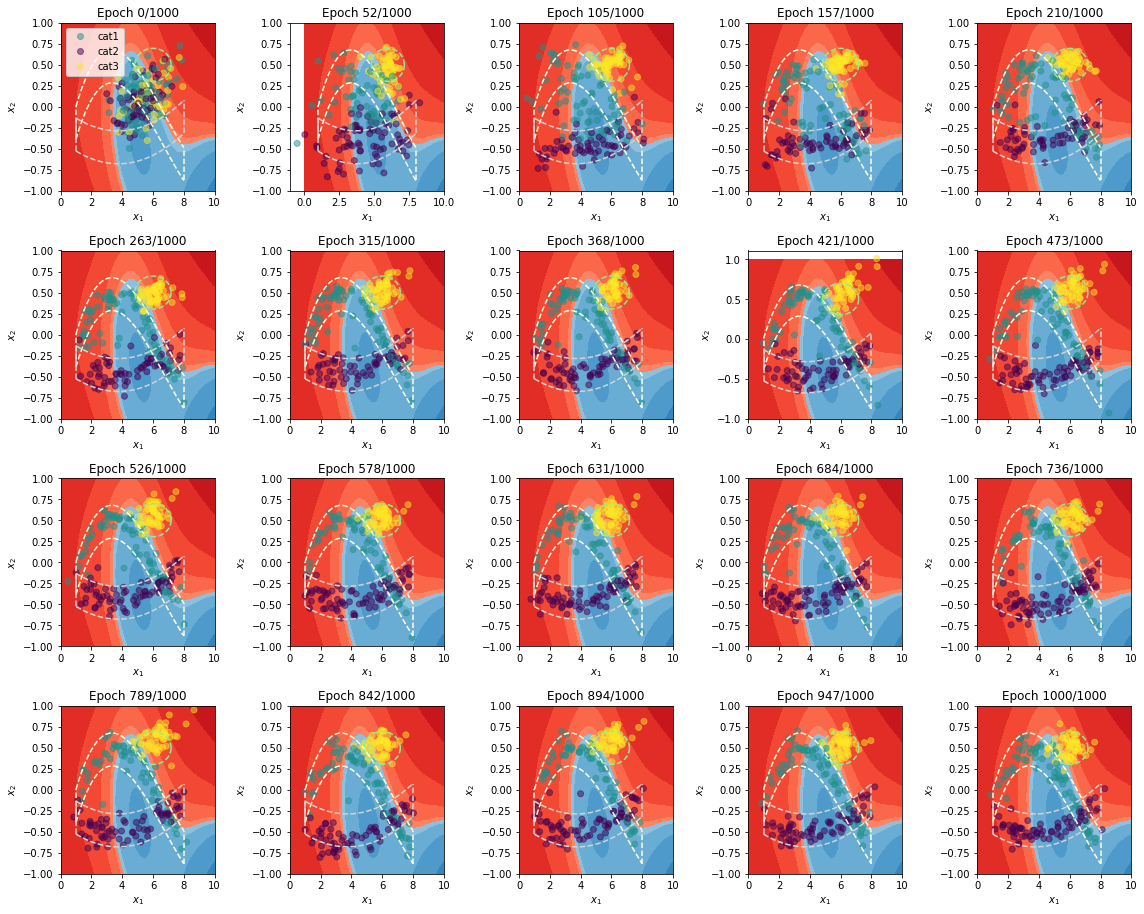

In [9]:
tg.train(n_epochs = 1000, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
             loss_plot_type = "line", progress_bar=True, plot2D_image = True, plot_loss = False, n_test=200,
         plot2D_discrete_col="x3", save_dir = image_dir, filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_train_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [14]:
%lprun -f fast_non_dominated_sort a = tg.generate_counterfactuals(50, classifier, tg.data.loc[0], n_to_generate = 10000, add_plausibility_objective =True)

In [20]:
tg.data.loc[244]

x1     5.29022
x2    0.358748
x3        cat1
Name: 244, dtype: object

In [16]:
a, d = tg.generate_counterfactuals(10, classifier, tg.data.loc[244], n_to_generate = 10000, add_plausibility_objective =False,
                                   return_objectives=True
                           )

In [22]:
a

,index,x1,x2,x3
55,103,5.951515,0.294872,cat1
4896,8940,3.560287,0.372990,cat1
1694,3165,3.520017,0.372960,cat1
106,196,3.511054,0.371157,cat1
2147,4014,3.600526,0.391666,cat1
2717,4998,3.634194,0.400316,cat1
4419,8050,3.584916,0.392278,cat1
5235,9544,3.423878,0.359704,cat1
5486,9997,3.558719,0.393425,cat1
4973,9085,3.562369,0.399107,cat1


In [24]:
pd.DataFrame(d)

,0,1
0,0.105554,0.333333
1,0.214791,0.666667
2,0.380945,0.666667
3,0.612738,1.000000
4,0.194327,0.666667
...,...,...
5483,0.396725,1.000000
5484,0.281798,0.666667
5485,0.405569,1.000000
5486,0.080054,0.333333


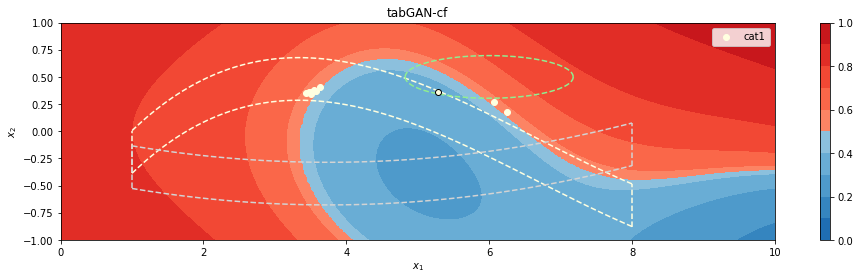

In [10]:
cf_dir = ".//Counterfactuals"
%run "$utils_path"
compare_counterfactuals(df_toy, x_obs_nr = 244, save_path = "compare_counterfactuals_for_obs0.jpg", save_dir=image_dir,
                       only_tabGAN_cf = True)

In [101]:
df_toy.loc[(df_toy["x3"] == "cat1") & (df_toy["x2"] > 0.25) & (df_toy["x1"] > 5)]

,x1,x2,x3
104,5.027989,0.276281,cat1
114,5.232001,0.254248,cat1
219,5.115578,0.272735,cat1
232,5.134171,0.250008,cat1
244,5.290220,0.358748,cat1
556,5.018416,0.257121,cat1
576,5.141393,0.362920,cat1
601,5.354484,0.260946,cat1
685,5.189755,0.315741,cat1
835,5.046560,0.439574,cat1


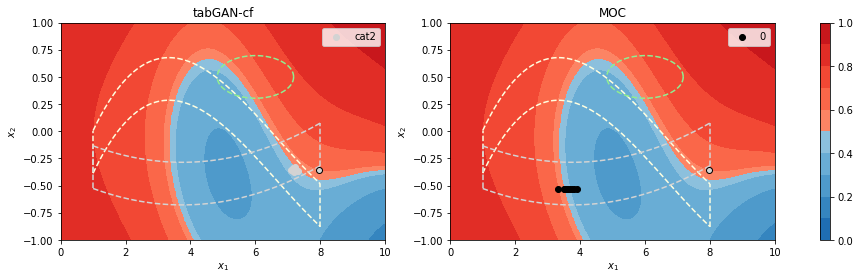

In [112]:
compare_counterfactuals(df_toy, x_obs_nr=0, save_path = "compare_counterfactuals_for_obs1.jpg", save_dir=image_dir)